# Phase 4: Physician Payment Linkage — OP↔Medicare & Medicare↔PECOS

This notebook is the unified Phase 4 of the physician record linkage project. It:
- Scores candidate pairs from Phase 3 using string/phonetic/address similarity features
- Classifies matches via a five-path rule-based classifier
- Evaluates precision and recall against a ground-truth set
- Links Medicare↔PECOS via NPI (absorbed from old `4.2_medpecos_linkage.ipynb`)
- Trains ML classifiers (Logistic Regression, Random Forest, XGBoost) on pseudo-labels
- Performs threshold sensitivity analysis with bootstrap confidence intervals
- Exports feature matrices, match files, and visualizations

### 4.0 — Imports & Configuration

- Import core libraries: pandas, numpy, os, time, seaborn, matplotlib
- Import string-distance utilities from `rapidfuzz`
- Set input/output directory paths for Phase 2 (preprocessing), Phase 3 (blocking), and Phase 4 (linkage)
- Create output directory if it doesn't exist

In [28]:
# ============================================================
# 4.0 IMPORTS & CONFIGURATION
# ============================================================

import pandas as pd
import numpy as np
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from rapidfuzz.distance import JaroWinkler, Levenshtein

INPUT_DIR = "../artifacts/phase2_preprocessing/"
BLOCKING_DIR = "../artifacts/phase3_blocking/"
OUTPUT_DIR = "../artifacts/phase4_linkage/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("4.0 IMPORTS & CONFIGURATION")
print("-" * 60)
print(f"INPUT_DIR:    {INPUT_DIR}")
print(f"BLOCKING_DIR: {BLOCKING_DIR}")
print(f"OUTPUT_DIR:   {OUTPUT_DIR}")
print("All imports loaded successfully.")

4.0 IMPORTS & CONFIGURATION
------------------------------------------------------------
INPUT_DIR:    ../artifacts/phase2_preprocessing/
BLOCKING_DIR: ../artifacts/phase3_blocking/
OUTPUT_DIR:   ../artifacts/phase4_linkage/
All imports loaded successfully.


### 4.1 — Load Candidate Pairs & Build Comparison DataFrame [REWRITE]

- Load cleaned Open Payments and Medicare datasets from Phase 2
- Filter OP to `tier2_fuzzy` and apply `reset_index(drop=True)` for index alignment with Phase 3 pairs
- Load `candidate_pairs.parquet` from Phase 3 (Union of all 5 blocking strategies: ~492,427 pairs)
- Build `op_fields` and `med_fields` DataFrames with renamed columns
- Merge to create `comp_df` — the comparison DataFrame used for all downstream scoring

**CRITICAL:** Phase 3 used `reset_index(drop=True)` on both `op_tier2` and `med_clean`. We must do the same here so `index_op` and `index_med` align correctly.

In [29]:
# ============================================================
# 4.1 LOAD CANDIDATE PAIRS & BUILD COMPARISON DATAFRAME
# ============================================================

print("4.1 LOAD CANDIDATE PAIRS & BUILD COMPARISON DATAFRAME")
print("-" * 60)

# Load cleaned datasets
op_clean = pd.read_parquet(os.path.join(INPUT_DIR, 'open_payments_clean.parquet'))
med_clean = pd.read_parquet(os.path.join(INPUT_DIR, 'medicare_clean.parquet'))

# Filter to tier2 and reset index (CRITICAL for alignment with Phase 3 pairs)
op_tier2 = op_clean[op_clean['linkage_tier'] == 'tier2_fuzzy'].copy().reset_index(drop=True)
med_clean = med_clean.reset_index(drop=True)

print(f"Open Payments tier2_fuzzy: {len(op_tier2):,}")
print(f"Medicare providers:        {len(med_clean):,}")

# Load candidate pairs from Phase 3 (Union of all 5 blocking strategies)
all_pairs = pd.read_parquet(os.path.join(BLOCKING_DIR, 'candidate_pairs.parquet'))
print(f"Candidate pairs loaded:    {len(all_pairs):,}")
assert len(all_pairs) > 400_000, f"Expected ~492,427 pairs, got {len(all_pairs):,}"

# Build OP fields DataFrame with normalized column names
op_fields = op_tier2[[
    'Covered_Recipient_First_Name', 'Covered_Recipient_Last_Name',
    'Recipient_Primary_Business_Street_Address_Line1',
    'Recipient_City', 'Recipient_State', 'Recipient_Zip5',
    'FIRST_NAME_SOUNDEX', 'LAST_NAME_SOUNDEX',
    'FIRST_NAME_METAPHONE', 'LAST_NAME_METAPHONE'
]].rename(columns={
    'Covered_Recipient_First_Name': 'first_name_op',
    'Covered_Recipient_Last_Name': 'last_name_op',
    'Recipient_Primary_Business_Street_Address_Line1': 'street_op',
    'Recipient_City': 'city_op',
    'Recipient_State': 'state_op',
    'Recipient_Zip5': 'zip5_op',
    'FIRST_NAME_SOUNDEX': 'first_soundex_op',
    'LAST_NAME_SOUNDEX': 'last_soundex_op',
    'FIRST_NAME_METAPHONE': 'first_metaphone_op',
    'LAST_NAME_METAPHONE': 'last_metaphone_op'
})

# Build Medicare fields DataFrame with normalized column names
med_fields = med_clean[[
    'Rndrng_Prvdr_First_Name', 'Rndrng_Prvdr_Last_Org_Name',
    'Rndrng_Prvdr_St1', 'Rndrng_Prvdr_City',
    'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_Zip5',
    'FIRST_NAME_SOUNDEX', 'LAST_NAME_SOUNDEX',
    'FIRST_NAME_METAPHONE', 'LAST_NAME_METAPHONE'
]].rename(columns={
    'Rndrng_Prvdr_First_Name': 'first_name_med',
    'Rndrng_Prvdr_Last_Org_Name': 'last_name_med',
    'Rndrng_Prvdr_St1': 'street_med',
    'Rndrng_Prvdr_City': 'city_med',
    'Rndrng_Prvdr_State_Abrvtn': 'state_med',
    'Rndrng_Prvdr_Zip5': 'zip5_med',
    'FIRST_NAME_SOUNDEX': 'first_soundex_med',
    'LAST_NAME_SOUNDEX': 'last_soundex_med',
    'FIRST_NAME_METAPHONE': 'first_metaphone_med',
    'LAST_NAME_METAPHONE': 'last_metaphone_med'
})

# Build comparison DataFrame
comp_df = all_pairs.merge(op_fields, left_on='index_op', right_index=True, how='left')
comp_df = comp_df.merge(med_fields, left_on='index_med', right_index=True, how='left')

print(f"\nComparison DataFrame shape: {comp_df.shape}")
print(f"Columns: {list(comp_df.columns)}")

print("\nSample pairs (first 10):")
print(comp_df[['first_name_op', 'first_name_med',
               'last_name_op', 'last_name_med',
               'state_op', 'state_med']].head(10))

4.1 LOAD CANDIDATE PAIRS & BUILD COMPARISON DATAFRAME
------------------------------------------------------------
Open Payments tier2_fuzzy: 4,683
Medicare providers:        1,175,281
Candidate pairs loaded:    492,427

Comparison DataFrame shape: (492427, 22)
Columns: ['index_op', 'index_med', 'first_name_op', 'last_name_op', 'street_op', 'city_op', 'state_op', 'zip5_op', 'first_soundex_op', 'last_soundex_op', 'first_metaphone_op', 'last_metaphone_op', 'first_name_med', 'last_name_med', 'street_med', 'city_med', 'state_med', 'zip5_med', 'first_soundex_med', 'last_soundex_med', 'first_metaphone_med', 'last_metaphone_med']

Sample pairs (first 10):
  first_name_op first_name_med last_name_op last_name_med state_op state_med
0        TERESA           AXEL     RENTERIA      RENTERIA       CA        CA
1          LALI         GEORGE       GEORGE          HALL       TX        TX
2       MICHAEL        MICHAEL      CAMERON       GOLINKO       TN        TN
3          JOHN         ROBERT    P

### 4.2 — Compute Similarity Features [KEEP + ENHANCE]

Computes the full set of similarity features for each candidate pair:

**Existing features (kept from old notebook):**
- Name similarities: `first_jw`, `first_lev`, `last_jw`, `last_lev` (Jaro-Winkler and normalized Levenshtein)
- Phonetic matches: `first_soundex_match`, `last_soundex_match`, `first_metaphone_match`, `last_metaphone_match`
- Address similarities: `street_jw`, `city_match`, `state_match`, `zip5_match`
- Composites: `name_avg`, `addr_avg`, `raw_score`

**New features added:**
- `name_len_ratio`: min/max length ratio of first names — cheap signal for length similarity
- `full_name_jw`: Jaro-Winkler on concatenated "first last" strings — captures swapped or hyphenated names

In [30]:
# ============================================================
# 4.2 COMPUTE ALL SIMILARITY FEATURES
# ============================================================

print("4.2 COMPUTE ALL SIMILARITY FEATURES")
print("-" * 60)

t0 = time.time()

# --- Jaro-Winkler helper (0-1 scale) ---
def jw_sim(s1: pd.Series, s2: pd.Series) -> pd.Series:
    return pd.Series(
        [JaroWinkler.similarity(str(a), str(b)) if (pd.notna(a) and pd.notna(b)) else 0.0
         for a, b in zip(s1, s2)],
        index=s1.index
    )

# --- Normalized Levenshtein helper (0-1 scale) ---
def norm_lev(s1: pd.Series, s2: pd.Series) -> pd.Series:
    return pd.Series(
        [Levenshtein.normalized_similarity(str(a), str(b)) if (pd.notna(a) and pd.notna(b)) else 0.0
         for a, b in zip(s1, s2)],
        index=s1.index
    )

# --- Exact match helper ---
def exact_match(s1: pd.Series, s2: pd.Series) -> pd.Series:
    return (s1.fillna('').astype(str).str.upper() == s2.fillna('').astype(str).str.upper()).astype(float)

# --- Name similarities ---
print("Computing name similarities...")
comp_df['first_jw'] = jw_sim(comp_df['first_name_op'], comp_df['first_name_med'])
comp_df['first_lev'] = norm_lev(comp_df['first_name_op'], comp_df['first_name_med'])
comp_df['last_jw'] = jw_sim(comp_df['last_name_op'], comp_df['last_name_med'])
comp_df['last_lev'] = norm_lev(comp_df['last_name_op'], comp_df['last_name_med'])

# --- Phonetic matches ---
print("Computing phonetic matches...")
comp_df['first_soundex_match'] = exact_match(comp_df['first_soundex_op'], comp_df['first_soundex_med'])
comp_df['last_soundex_match'] = exact_match(comp_df['last_soundex_op'], comp_df['last_soundex_med'])
comp_df['first_metaphone_match'] = exact_match(comp_df['first_metaphone_op'], comp_df['first_metaphone_med'])
comp_df['last_metaphone_match'] = exact_match(comp_df['last_metaphone_op'], comp_df['last_metaphone_med'])

# --- Address similarities ---
print("Computing address similarities...")
comp_df['street_jw'] = jw_sim(comp_df['street_op'], comp_df['street_med'])
comp_df['city_match'] = exact_match(comp_df['city_op'], comp_df['city_med'])
comp_df['state_match'] = exact_match(comp_df['state_op'], comp_df['state_med'])
comp_df['zip5_match'] = exact_match(comp_df['zip5_op'], comp_df['zip5_med'])

# --- Composites ---
comp_df['name_avg'] = (comp_df['first_jw'] + comp_df['last_jw']) / 2
comp_df['addr_avg'] = (comp_df['street_jw'] + comp_df['city_match'] + comp_df['zip5_match']) / 3
comp_df['raw_score'] = (comp_df['name_avg'] + comp_df['addr_avg']) / 2

# --- NEW: name_len_ratio ---
print("Computing new features: name_len_ratio, full_name_jw...")
fn_op_len = comp_df['first_name_op'].fillna('').astype(str).str.len()
fn_med_len = comp_df['first_name_med'].fillna('').astype(str).str.len()
min_len = pd.concat([fn_op_len, fn_med_len], axis=1).min(axis=1)
max_len = pd.concat([fn_op_len, fn_med_len], axis=1).max(axis=1)
comp_df['name_len_ratio'] = (min_len / max_len).fillna(0)

# --- NEW: full_name_jw ---
full_op = comp_df['first_name_op'].fillna('').astype(str) + ' ' + comp_df['last_name_op'].fillna('').astype(str)
full_med = comp_df['first_name_med'].fillna('').astype(str) + ' ' + comp_df['last_name_med'].fillna('').astype(str)
comp_df['full_name_jw'] = jw_sim(full_op, full_med)

elapsed = time.time() - t0
print(f"Done in {elapsed:.1f}s")

# --- Verify distributions ---
feature_cols = ['first_jw', 'first_lev', 'last_jw', 'last_lev',
                'first_soundex_match', 'last_soundex_match',
                'first_metaphone_match', 'last_metaphone_match',
                'street_jw', 'city_match', 'state_match', 'zip5_match',
                'name_avg', 'addr_avg', 'raw_score',
                'name_len_ratio', 'full_name_jw']

print("\nFeature distributions:")
print(comp_df[feature_cols].describe().round(4).to_string())

print(f"\nPairs with raw_score > 0.80: {(comp_df['raw_score'] > 0.80).sum():,}")
print(f"Pairs with raw_score > 0.70: {(comp_df['raw_score'] > 0.70).sum():,}")
print(f"Pairs with raw_score > 0.60: {(comp_df['raw_score'] > 0.60).sum():,}")
print(f"Pairs with name_avg > 0.90: {(comp_df['name_avg'] > 0.90).sum():,}")
print(f"\nElapsed time: {elapsed:.1f}s")

4.2 COMPUTE ALL SIMILARITY FEATURES
------------------------------------------------------------
Computing name similarities...
Computing phonetic matches...
Computing address similarities...
Computing new features: name_len_ratio, full_name_jw...
Done in 9.5s

Feature distributions:
          first_jw    first_lev      last_jw     last_lev  first_soundex_match  last_soundex_match  first_metaphone_match  last_metaphone_match    street_jw   city_match  state_match   zip5_match     name_avg     addr_avg    raw_score  name_len_ratio  full_name_jw
count  492427.0000  492427.0000  492427.0000  492427.0000          492427.0000         492427.0000            492427.0000           492427.0000  492427.0000  492427.0000     492427.0  492427.0000  492427.0000  492427.0000  492427.0000     492427.0000   492427.0000
mean        0.4688       0.2231       0.7343       0.5407               0.0940              0.8687                 0.0915                0.5018       0.5447       0.0505          1.0   

### 4.3 — Rule-Based Match Classification (Five-Path) [KEEP EXACTLY]

Classifies every candidate pair into **match**, **possible**, or **non_match** using five deterministic paths.

**Name rarity**
- Builds a `(first, last, state)` key for every Medicare record and counts how many providers share each key (`fls_count`)
- This count drives a rarity-aware gate in Path D: common names need stronger geographic confirmation

| Path | Logic | Intuition |
|------|-------|----------|
| **A** | `first_jw ≥ 0.85` + `last_jw ≥ 0.85` + ZIP or street anchor | Both names fuzzy-strong with address backup |
| **B** | Exact last + `first_lev ≥ 0.60` + exact ZIP + exact city | Exact surname with full geographic lock |
| **C2** | `first_jw ≥ 0.92` + `first_lev ≥ 0.75` + exact last + ZIP or city | High first-name confidence with exact surname |
| **D** | Exact first + exact last + same state; if `fls_count > 3`, also require city or ZIP | Exact full name — rarity-gated |
| **E** | Exact last + `first_jw ≥ 0.90` + `first_lev ≥ 0.80` + same city + state | Strong first name with city+state lock |

**Possible tier** — pairs that miss all match paths but still show reasonable name similarity + at least one geographic anchor.

In [31]:
# ============================================================
# 4.3 MATCH CLASSIFICATION — FIVE-PATH RULES WITH NAME RARITY
# ============================================================

print("4.3 MATCH CLASSIFICATION — FIVE-PATH RULES")
print("-" * 60)

med_clean['fls_key'] = (
    med_clean['Rndrng_Prvdr_First_Name'].str.upper().fillna('') + '|' +
    med_clean['Rndrng_Prvdr_Last_Org_Name'].str.upper().fillna('') + '|' +
    med_clean['Rndrng_Prvdr_State_Abrvtn'].fillna('')
)

fls_counts = med_clean['fls_key'].value_counts()
print(f"Unique (first+last+state) in Medicare: {len(fls_counts):,}")
print(f"  Appearing once: {(fls_counts == 1).sum():,}")
print(f"  Appearing 2-3x: {((fls_counts >= 2) & (fls_counts <= 3)).sum():,}")
print(f"  Appearing >3x: {(fls_counts > 3).sum():,}")

comp_df['fls_key_med'] = (
    comp_df['first_name_med'].str.upper().fillna('') + '|' +
    comp_df['last_name_med'].str.upper().fillna('') + '|' +
    comp_df['state_med'].fillna('')
)
comp_df['fls_count'] = comp_df['fls_key_med'].map(fls_counts).fillna(0).astype(int)

path_a = (
    (comp_df['first_jw'] >= 0.85) &
    (comp_df['last_jw'] >= 0.85) &
    ((comp_df['zip5_match'] == 1.0) | (comp_df['street_jw'] >= 0.80))
)

path_b = (
    (comp_df['last_lev'] == 1.0) &
    (comp_df['first_lev'] >= 0.60) &
    (comp_df['zip5_match'] == 1.0) &
    (comp_df['city_match'] == 1.0)
)

path_c2 = (
    (comp_df['first_jw'] >= 0.92) &
    (comp_df['first_lev'] >= 0.75) &
    (comp_df['last_jw'] == 1.0) &
    ((comp_df['zip5_match'] == 1.0) | (comp_df['city_match'] == 1.0))
)

path_d = (
    (comp_df['first_lev'] == 1.0) &
    (comp_df['last_lev'] == 1.0) &
    (comp_df['state_match'] == 1.0) &
    (
        (comp_df['fls_count'] <= 3) |
        ((comp_df['fls_count'] > 3) & ((comp_df['city_match'] == 1.0) | (comp_df['zip5_match'] == 1.0)))
    )
)

path_e = (
    (comp_df['last_lev'] == 1.0) &
    (comp_df['first_jw'] >= 0.90) &
    (comp_df['first_lev'] >= 0.80) &
    (comp_df['city_match'] == 1.0) &
    (comp_df['state_match'] == 1.0)
)

match_mask = path_a | path_b | path_c2 | path_d | path_e

possible_mask = (
    ~match_mask &
    (comp_df['first_jw'] >= 0.65) &
    (comp_df['first_lev'] >= 0.60) &
    (comp_df['last_jw'] >= 0.90) &
    ((comp_df['zip5_match'] == 1.0) | (comp_df['city_match'] == 1.0) | (comp_df['street_jw'] >= 0.70))
)

comp_df['match_tier'] = 'non_match'
comp_df.loc[possible_mask, 'match_tier'] = 'possible'
comp_df.loc[match_mask, 'match_tier'] = 'match'

# FIX: np.select assigns the FIRST qualifying path (not last).
# Old code used sequential .loc which let Path D overwrite A/B/C2.
comp_df['which_path'] = pd.Series(
    np.select(
        [path_a, path_b, path_c2, path_d, path_e, possible_mask],
        ['A', 'B', 'C2', 'D', 'E', 'possible'],
        default='none'
    ),
    index=comp_df.index
)

tier_counts = comp_df['match_tier'].value_counts()
print(f"\nTier counts:")
for tier, cnt in tier_counts.items():
    print(f"  {tier:12s}: {cnt:>10,}")

print(f"\n  Path A (raw boolean):  {path_a.sum():,}")
print(f"  Path B (raw boolean):  {path_b.sum():,}")
print(f"  Path C2 (raw boolean): {path_c2.sum():,}")
print(f"  Path D (raw boolean):  {path_d.sum():,}")
print(f"  Path E (raw boolean):  {path_e.sum():,}")

matches = comp_df[comp_df['match_tier'] == 'match']
possibles = comp_df[comp_df['match_tier'] == 'possible']

print(f"\nUnique OP in 'match':    {matches['index_op'].nunique():,}")
print(f"Unique OP in 'possible': {possibles['index_op'].nunique():,}")
print(f"Total tier2 OP records:  {len(op_tier2):,}")

print(f"\nwhich_path distribution (first qualifying path wins):")
print(comp_df['which_path'].value_counts().to_string())


4.3 MATCH CLASSIFICATION — FIVE-PATH RULES
------------------------------------------------------------
Unique (first+last+state) in Medicare: 1,118,890
  Appearing once: 1,098,822
  Appearing 2-3x: 18,373
  Appearing >3x: 1,695

Tier counts:
  non_match   :    491,869
  match       :        482
  possible    :         76

  Path A (raw boolean):  103
  Path B (raw boolean):  91
  Path C2 (raw boolean): 129
  Path D (raw boolean):  456
  Path E (raw boolean):  127

Unique OP in 'match':    393
Unique OP in 'possible': 64
Total tier2 OP records:  4,683

which_path distribution (first qualifying path wins):
which_path
none        491869
D              333
A              103
possible        76
C2              43
B                3


### 4.4 — Recall Ceiling Diagnostic [KEEP EXACTLY]

Measures how many tier-2 OP records are **theoretically findable** in Medicare:
- Builds three progressively stricter lookup sets from Medicare: last name only, (first, last), (first, last, state)
- Checks OP coverage at each level
- Compares already-matched vs unmatched OP records
- Reports `RECALL CEILING` and `GAP TO CLOSE`

In [32]:
# ============================================================
# 4.4 RECALL CEILING DIAGNOSTIC
# ============================================================

print("4.4 RECALL CEILING DIAGNOSTIC")
print("-" * 60)

# Build lookup sets from Medicare
med_last_names = set(med_clean['Rndrng_Prvdr_Last_Org_Name'].str.upper().dropna())
med_full_names = set(
    zip(med_clean['Rndrng_Prvdr_First_Name'].str.upper().fillna(''),
        med_clean['Rndrng_Prvdr_Last_Org_Name'].str.upper().fillna(''))
)
med_full_names_state = set(
    zip(med_clean['Rndrng_Prvdr_First_Name'].str.upper().fillna(''),
        med_clean['Rndrng_Prvdr_Last_Org_Name'].str.upper().fillna(''),
        med_clean['Rndrng_Prvdr_State_Abrvtn'].fillna(''))
)

# Check tier2 OP records
op_t2 = op_tier2.copy()
op_t2['first_up'] = op_t2['Covered_Recipient_First_Name'].str.upper().fillna('')
op_t2['last_up'] = op_t2['Covered_Recipient_Last_Name'].str.upper().fillna('')

op_t2['last_in_med'] = op_t2['last_up'].isin(med_last_names)

op_t2['fullname_in_med'] = list(zip(op_t2['first_up'], op_t2['last_up']))
op_t2['fullname_in_med'] = op_t2['fullname_in_med'].isin(med_full_names)

op_t2['fns_in_med'] = list(zip(op_t2['first_up'], op_t2['last_up'], op_t2['Recipient_State'].fillna('')))
op_t2['fns_in_med'] = op_t2['fns_in_med'].isin(med_full_names_state)

total = len(op_t2)
print(f"Total tier2 OP records: {total:,}")
print(f"Last name found in Medicare:        {op_t2['last_in_med'].sum():,} ({op_t2['last_in_med'].mean()*100:.1f}%)")
print(f"First+Last found in Medicare:       {op_t2['fullname_in_med'].sum():,} ({op_t2['fullname_in_med'].mean()*100:.1f}%)")
print(f"First+Last+State found in Medicare: {op_t2['fns_in_med'].sum():,} ({op_t2['fns_in_med'].mean()*100:.1f}%)")

# Already matched
already_matched = set(matches['index_op'].unique())
matched_fns = op_t2.loc[op_t2.index.isin(already_matched), 'fns_in_med'].sum()
print(f"\nAlready matched: {len(already_matched):,}")
print(f"  of which have F+L+State in Med: {matched_fns:,}")

# Unmatched but findable
unmatched = op_t2[~op_t2.index.isin(already_matched)]
print(f"\nUnmatched OP records: {len(unmatched):,}")
print(f"  Last name in Medicare:        {unmatched['last_in_med'].sum():,} ({unmatched['last_in_med'].mean()*100:.1f}%)")
print(f"  First+Last in Medicare:       {unmatched['fullname_in_med'].sum():,} ({unmatched['fullname_in_med'].mean()*100:.1f}%)")
print(f"  First+Last+State in Medicare: {unmatched['fns_in_med'].sum():,} ({unmatched['fns_in_med'].mean()*100:.1f}%)")

ceiling_fns = (unmatched['fns_in_med'].sum() + len(already_matched)) / total * 100
ceiling_fn = (unmatched['fullname_in_med'].sum() + len(already_matched)) / total * 100

print(f"\n{'='*50}")
print(f"  RECALL CEILING (First+Last+State): {ceiling_fns:.1f}%")
print(f"  RECALL CEILING (First+Last, any st): {ceiling_fn:.1f}%")
print(f"  CURRENT LINK RATE: {len(already_matched)/total*100:.1f}%")
print(f"  GAP TO CLOSE: {ceiling_fns - len(already_matched)/total*100:.1f}pp")
print(f"{'='*50}")

4.4 RECALL CEILING DIAGNOSTIC
------------------------------------------------------------
Total tier2 OP records: 4,683
Last name found in Medicare:        4,082 (87.2%)
First+Last found in Medicare:       1,300 (27.8%)
First+Last+State found in Medicare: 381 (8.1%)

Already matched: 393
  of which have F+L+State in Med: 374

Unmatched OP records: 4,290
  Last name in Medicare:        3,690 (86.0%)
  First+Last in Medicare:       922 (21.5%)
  First+Last+State in Medicare: 7 (0.2%)

  RECALL CEILING (First+Last+State): 8.5%
  RECALL CEILING (First+Last, any st): 28.1%
  CURRENT LINK RATE: 8.4%
  GAP TO CLOSE: 0.1pp


### 4.5 — Ground Truth & Precision/Recall Evaluation [KEEP EXACTLY]

Constructs a ground-truth set and evaluates the five-path classifier:
- **Ground truth construction**: tier-2 OP records whose exact (first, last, state) triple exists in Medicare
- **Recall (record-level)**: how many ground-truth OP records were found by match/possible tiers
- **Precision (lower bound)**: of linked OP records, how many appear in ground truth
- **Pair-level accuracy**: whether matched pairs point to the correct Medicare record
- **False negative inspection**: sample of missed ground-truth records

In [33]:
# ============================================================
# 4.5 BUILD GROUND TRUTH & MEASURE PRECISION / RECALL
# ============================================================

print("4.5 BUILD GROUND TRUTH & MEASURE PRECISION / RECALL")
print("-" * 60)

from collections import defaultdict

gt_op = op_t2[op_t2['fns_in_med'] == True].copy()
print(f"Ground truth OP records (exact F+L+State in Medicare): {len(gt_op):,}")

# Build a lookup from Medicare: (first, last, state) → list of Medicare indices
med_lookup = defaultdict(list)
for idx, row in med_clean.iterrows():
    key = (
        str(row['Rndrng_Prvdr_First_Name']).upper().strip(),
        str(row['Rndrng_Prvdr_Last_Org_Name']).upper().strip(),
        str(row['Rndrng_Prvdr_State_Abrvtn']).strip()
    )
    med_lookup[key].append(idx)

# For each GT OP record, find all possible Medicare matches
gt_pairs = []
for idx, row in gt_op.iterrows():
    key = (row['first_up'], row['last_up'], str(row['Recipient_State']).strip())
    med_indices = med_lookup.get(key, [])
    for med_idx in med_indices:
        gt_pairs.append({'index_op': idx, 'index_med': med_idx})

gt_pairs_df = pd.DataFrame(gt_pairs)
print(f"Ground truth pairs (OP × Medicare): {len(gt_pairs_df):,}")
print(f"Unique OP in ground truth: {gt_pairs_df['index_op'].nunique():,}")

# --- RECALL ---
our_match_ops = set(matches['index_op'].unique())
our_possible_ops = set(possibles['index_op'].unique())
gt_ops = set(gt_pairs_df['index_op'].unique())

tp_match = gt_ops & our_match_ops
tp_possible = gt_ops & our_possible_ops
tp_combined = gt_ops & (our_match_ops | our_possible_ops)
fn = gt_ops - (our_match_ops | our_possible_ops)

print(f"\n--- RECALL (on ground truth subset) ---")
print(f"Ground truth OP records: {len(gt_ops):,}")
print(f"Found by 'match' tier:   {len(tp_match):,}")
print(f"Found by 'possible' tier: {len(tp_possible):,}")
print(f"Found by match OR possible: {len(tp_combined):,}")
print(f"Missed (false negatives): {len(fn):,}")
print(f"RECALL (match only): {len(tp_match)/len(gt_ops)*100:.1f}%")
print(f"RECALL (match + possible): {len(tp_combined)/len(gt_ops)*100:.1f}%")

# --- PRECISION ---
our_all = our_match_ops | our_possible_ops
in_gt = our_all & gt_ops
not_in_gt = our_all - gt_ops

print(f"\n--- PRECISION (lower bound, on ground truth subset) ---")
print(f"Our linked OP records (m+p): {len(our_all):,}")
print(f"  In ground truth: {len(in_gt):,}")
print(f"  Not in ground truth: {len(not_in_gt):,}")
print(f"PRECISION (lower bound): {len(in_gt)/len(our_all)*100:.1f}%")

# --- PAIR-LEVEL ACCURACY ---
our_match_pairs = set(zip(matches['index_op'], matches['index_med']))
gt_pair_set = set(zip(gt_pairs_df['index_op'], gt_pairs_df['index_med']))

pair_tp = our_match_pairs & gt_pair_set
print(f"\n--- PAIR-LEVEL ACCURACY ---")
print(f"Our match pairs:     {len(our_match_pairs):,}")
print(f"Ground truth pairs:  {len(gt_pair_set):,}")
print(f"Correct pairs (TP):  {len(pair_tp):,}")
print(f"Pair-level precision: {len(pair_tp)/len(our_match_pairs)*100:.1f}%")

# --- Preview false negatives ---
fn_list = list(fn)[:10]
if fn_list:
    fn_sample = op_t2.loc[fn_list, ['first_up','last_up','Recipient_State',
                                     'Recipient_City','Recipient_Zip5']]
    print(f"\n--- Sample FALSE NEGATIVES (in GT but we missed them) ---")
    print(fn_sample.to_string())
else:
    print("\nNo false negatives — all ground truth records matched!")

4.5 BUILD GROUND TRUTH & MEASURE PRECISION / RECALL
------------------------------------------------------------
Ground truth OP records (exact F+L+State in Medicare): 381
Ground truth pairs (OP × Medicare): 526
Unique OP in ground truth: 381

--- RECALL (on ground truth subset) ---
Ground truth OP records: 381
Found by 'match' tier:   374
Found by 'possible' tier: 17
Found by match OR possible: 374
Missed (false negatives): 7
RECALL (match only): 98.2%
RECALL (match + possible): 98.2%

--- PRECISION (lower bound, on ground truth subset) ---
Our linked OP records (m+p): 438
  In ground truth: 374
  Not in ground truth: 64
PRECISION (lower bound): 85.4%

--- PAIR-LEVEL ACCURACY ---
Our match pairs:     482
Ground truth pairs:  526
Correct pairs (TP):  456
Pair-level precision: 94.6%

--- Sample FALSE NEGATIVES (in GT but we missed them) ---
     first_up  last_up Recipient_State  Recipient_City Recipient_Zip5
588      JOHN      LEE              PA       BRYN MAWR          19010
1008    

### 4.6 — Medicare ↔ PECOS Linkage (NPI Join) [ABSORB FROM 4.2]

This section absorbs the entire old `4.2_medpecos_linkage.ipynb` into one section:
- Load `pecos_clean.parquet` and filter to individuals (`ENRLMT_ENTITY == "I"`) → ~2,502,376 records
- Filter Medicare to individuals with valid NPI → ~1,113,417 records
- Inner merge on `Rndrng_NPI == NPI` → ~1,331,556 pairs, ~1,084,185 unique NPIs
- Deduplicate to canonical links: sort by (NPI, ENRLMT_YEAR desc), keep most recent enrollment
- Save to `med_pecos_tier1_npi.parquet` in OUTPUT_DIR

In [34]:
# ============================================================
# 4.6 MEDICARE ↔ PECOS LINKAGE (NPI JOIN)
# ============================================================

print("4.6 MEDICARE ↔ PECOS LINKAGE (NPI JOIN)")
print("-" * 60)

# Load PECOS
pecos_clean = pd.read_parquet(os.path.join(INPUT_DIR, 'pecos_clean.parquet'))
print(f"PECOS enrollments: {len(pecos_clean):,}")

# Filter PECOS to individuals only
pecos_indiv = pecos_clean[pecos_clean['ENRLMT_ENTITY'] == 'I'].copy()
print(f"PECOS individuals: {len(pecos_indiv):,}")

# Filter Medicare to individuals with valid NPI
med_indiv = med_clean[med_clean['Rndrng_Prvdr_Ent_Cd'] == 'I'].copy()
med_indiv = med_indiv[med_indiv['NPI_VALID']].copy()
print(f"Medicare individuals (valid NPI): {len(med_indiv):,}")

# Inner merge on NPI
tier1_pairs = (
    med_indiv.reset_index()
    .merge(
        pecos_indiv.reset_index(),
        left_on='Rndrng_NPI',
        right_on='NPI',
        suffixes=('_med', '_pecos'),
        how='inner',
    )
)

print(f"\nTier 1 Med–PECOS NPI pairs: {len(tier1_pairs):,}")
print(f"Unique Medicare NPIs linked: {tier1_pairs['Rndrng_NPI'].nunique():,}")
print(f"Unique PECOS NPIs linked:    {tier1_pairs['NPI'].nunique():,}")

# Deduplicate to canonical links (most recent enrollment per NPI)
tier1_pairs['ENRLMT_YEAR'] = tier1_pairs['ENRLMT_YEAR'].astype('Int64')

tier1_canonical = (
    tier1_pairs
    .sort_values(['Rndrng_NPI', 'ENRLMT_YEAR'], ascending=[True, False])
    .drop_duplicates(subset=['Rndrng_NPI'], keep='first')
    .copy()
)

print(f"Canonical Med–PECOS links: {len(tier1_canonical):,}")

# Select output columns and save
cols = [
    'Rndrng_NPI',
    'Rndrng_Prvdr_First_Name',
    'Rndrng_Prvdr_Last_Org_Name',
    'Rndrng_Prvdr_State_Abrvtn',
    'ENRLMT_ID',
    'ENRLMT_YEAR',
    'FIRST_NAME',
    'LAST_NAME',
    'STATE_CD',
]

med_pecos_tier1 = tier1_canonical[cols].copy()

outpath = os.path.join(OUTPUT_DIR, 'med_pecos_tier1_npi.parquet')
med_pecos_tier1.to_parquet(outpath, index=False)
print(f"\nSaved Med–PECOS Tier 1 to {outpath}")

print(f"\nSample canonical links:")
print(med_pecos_tier1.sample(10, random_state=42).to_string())

4.6 MEDICARE ↔ PECOS LINKAGE (NPI JOIN)
------------------------------------------------------------
PECOS enrollments: 2,936,748
PECOS individuals: 2,502,376
Medicare individuals (valid NPI): 1,113,417

Tier 1 Med–PECOS NPI pairs: 1,331,556
Unique Medicare NPIs linked: 1,084,185
Unique PECOS NPIs linked:    1,084,185
Canonical Med–PECOS links: 1,084,185

Saved Med–PECOS Tier 1 to ../artifacts/phase4_linkage/med_pecos_tier1_npi.parquet

Sample canonical links:
         Rndrng_NPI Rndrng_Prvdr_First_Name Rndrng_Prvdr_Last_Org_Name Rndrng_Prvdr_State_Abrvtn        ENRLMT_ID  ENRLMT_YEAR   FIRST_NAME  LAST_NAME STATE_CD
403088   1306171269                  JOSHUA                       DOTY                        MA  I20161026000821         2016       JOSHUA       DOTY       MA
14821    1013087139                   LEIGH                        COX                        AR  I20060106000752         2006        LEIGH        COX       AR
1232303  1922341767             CHRISTOPHER            

In [35]:
# --- Org-level Med→PECOS NPI join ---
print("\n--- ORG-LEVEL Med→PECOS NPI JOIN ---")

pecos_org = pecos_clean[pecos_clean['ENRLMT_ENTITY'] == 'O'].copy()
med_org = med_clean[med_clean['Rndrng_Prvdr_Ent_Cd'] == 'O'].copy()
med_org = med_org[med_org['NPI_VALID']].copy()

print(f"PECOS org enrollments: {len(pecos_org):,}")
print(f"Medicare org providers (valid NPI): {len(med_org):,}")

tier1_org_pairs = (
    med_org.reset_index()
    .merge(
        pecos_org.reset_index(),
        left_on='Rndrng_NPI',
        right_on='NPI',
        suffixes=('_med', '_pecos'),
        how='inner',
    )
)

print(f"Tier-1 org NPI pairs: {len(tier1_org_pairs):,}")
print(f"Unique org NPIs linked: {tier1_org_pairs['Rndrng_NPI'].nunique():,}")

# Deduplicate — most recent enrollment per NPI
tier1_org_pairs['ENRLMT_YEAR'] = tier1_org_pairs['ENRLMT_YEAR'].astype('Int64')
tier1_org_canonical = (
    tier1_org_pairs
    .sort_values(['Rndrng_NPI', 'ENRLMT_YEAR'], ascending=[True, False])
    .drop_duplicates(subset='Rndrng_NPI', keep='first')
    .copy()
)

org_cols = [
    'Rndrng_NPI', 'Rndrng_Prvdr_Last_Org_Name',
    'Rndrng_Prvdr_State_Abrvtn',
    'ENRLMT_ID', 'ENRLMT_YEAR', 'ORG_NAME', 'STATE_CD',
]
# Adjust col names based on your PECOS schema
medpecos_org_tier1 = tier1_org_canonical[[c for c in org_cols if c in tier1_org_canonical.columns]].copy()

org_outpath = os.path.join(OUTPUT_DIR, 'medpecos_org_tier1_npi.parquet')
medpecos_org_tier1.to_parquet(org_outpath, index=False)
print(f"Canonical org links: {len(medpecos_org_tier1):,}")
print(f"Saved to {org_outpath}")



--- ORG-LEVEL Med→PECOS NPI JOIN ---
PECOS org enrollments: 434,372
Medicare org providers (valid NPI): 61,864
Tier-1 org NPI pairs: 61,134
Unique org NPIs linked: 54,278
Canonical org links: 54,278
Saved to ../artifacts/phase4_linkage/medpecos_org_tier1_npi.parquet


## 4.6.1 Scenario 1 — Tier-1 NPI Linkage: Precision/Recall Report

**Why this matters:** Tier-1 linkage is a deterministic inner join on NPI — by definition,
every linked pair shares the same 10-digit NPI, so **precision = 100%** (zero false positives).
The interesting metric is **recall (coverage):** what fraction of the eligible population was
successfully linked?

This cell computes:
- **OP↔Medicare Tier-1:** How many Open Payments records had a valid NPI that matched a Medicare provider?
- **Med↔PECOS Tier-1:** Coverage of Medicare individual providers linked to PECOS enrollments.
- **Med↔PECOS Org Tier-1:** Coverage of Medicare organization providers linked to PECOS enrollments.
- A summary table with precision, recall, and record counts for each Tier-1 linkage.


In [36]:
# =============================================================
# 4.6.1  SCENARIO 1 — TIER-1 NPI LINKAGE METRICS
# =============================================================
print("4.6.1 SCENARIO 1 — TIER-1 NPI PRECISION / RECALL REPORT")
print("-" * 60)

# ── OP↔Medicare Tier-1 (direct NPI match) ──────────────────
# Tier-1 OP records are those with a valid NPI that exists in Medicare
op_tier1 = op_clean[op_clean["linkage_tier"] == "tier1_npi"].copy()
med_npis = set(med_clean.loc[med_clean["NPI_VALID"], "Rndrng_NPI"].unique())

op_tier1_has_npi = op_tier1["Covered_Recipient_NPI"].dropna().astype(str)
op_tier1_matched = op_tier1_has_npi.isin(med_npis)

op_t1_total    = len(op_tier1)
op_t1_linked   = op_tier1_matched.sum()
op_t1_coverage = op_t1_linked / op_t1_total * 100 if op_t1_total else 0

print(f"\n{'='*50}")
print("OP↔Medicare  Tier-1 (NPI join)")
print(f"{'='*50}")
print(f"  OP tier-1 records (have NPI):     {op_t1_total:>10,}")
print(f"  Matched to Medicare NPI:          {op_t1_linked:>10,}")
print(f"  Precision (deterministic join):        100.0%")
print(f"  Recall (coverage):                    {op_t1_coverage:>6.1f}%")

# ── Med↔PECOS Individual Tier-1 ────────────────────────────
med_indiv_total  = len(med_clean[(med_clean["Rndrng_Prvdr_Ent_Cd"] == "I") & med_clean["NPI_VALID"]])
med_pecos_linked = len(tier1_canonical)  # from Section 4.6
med_pecos_cov    = med_pecos_linked / med_indiv_total * 100 if med_indiv_total else 0

# PECOS-side coverage
pecos_indiv_total = len(pecos_indiv)
pecos_linked      = tier1_canonical["Rndrng_NPI"].nunique()  # same as med side for 1:1
pecos_cov         = pecos_linked / pecos_indiv_total * 100 if pecos_indiv_total else 0

print(f"\n{'='*50}")
print("Med↔PECOS Individual  Tier-1 (NPI join)")
print(f"{'='*50}")
print(f"  Medicare individuals (valid NPI): {med_indiv_total:>10,}")
print(f"  Linked to PECOS:                  {med_pecos_linked:>10,}")
print(f"  Precision (deterministic join):        100.0%")
print(f"  Medicare-side recall:                 {med_pecos_cov:>6.1f}%")
print(f"  PECOS individuals:                {pecos_indiv_total:>10,}")
print(f"  PECOS-side recall:                    {pecos_cov:>6.1f}%")

# ── Med↔PECOS Organization Tier-1 ──────────────────────────
med_org_total  = len(med_clean[(med_clean["Rndrng_Prvdr_Ent_Cd"] == "O") & med_clean["NPI_VALID"]])
org_linked     = len(tier1_org_canonical)   # from org-level join above
org_cov        = org_linked / med_org_total * 100 if med_org_total else 0

pecos_org_total = len(pecos_org)
pecos_org_linked = tier1_org_canonical["Rndrng_NPI"].nunique()
pecos_org_cov    = pecos_org_linked / pecos_org_total * 100 if pecos_org_total else 0

print(f"\n{'='*50}")
print("Med↔PECOS Organization  Tier-1 (NPI join)")
print(f"{'='*50}")
print(f"  Medicare orgs (valid NPI):        {med_org_total:>10,}")
print(f"  Linked to PECOS:                  {org_linked:>10,}")
print(f"  Precision (deterministic join):        100.0%")
print(f"  Medicare-side recall:                 {org_cov:>6.1f}%")
print(f"  PECOS org enrollments:            {pecos_org_total:>10,}")
print(f"  PECOS-side recall:                    {pecos_org_cov:>6.1f}%")

# ── Summary table ───────────────────────────────────────────
import pandas as pd

summary = pd.DataFrame([
    {
        "Linkage":          "OP↔Medicare (Indiv)",
        "Method":           "NPI exact join",
        "Source Records":   f"{op_t1_total:,}",
        "Linked":           f"{op_t1_linked:,}",
        "Precision":        "100.0%",
        "Recall":           f"{op_t1_coverage:.1f}%",
    },
    {
        "Linkage":          "Med↔PECOS (Indiv)",
        "Method":           "NPI exact join",
        "Source Records":   f"{med_indiv_total:,}",
        "Linked":           f"{med_pecos_linked:,}",
        "Precision":        "100.0%",
        "Recall":           f"{med_pecos_cov:.1f}%",
    },
    {
        "Linkage":          "Med↔PECOS (Org)",
        "Method":           "NPI exact join",
        "Source Records":   f"{med_org_total:,}",
        "Linked":           f"{org_linked:,}",
        "Precision":        "100.0%",
        "Recall":           f"{org_cov:.1f}%",
    },
])

print(f"\n{'='*50}")
print("SCENARIO 1 — TIER-1 SUMMARY")
print(f"{'='*50}")
print(summary.to_string(index=False))

print(f"""
KEY TAKEAWAY:
  Tier-1 NPI joins are deterministic → Precision = 100% by construction.
  The primary evaluation axis is RECALL (coverage).
  - OP↔Med:  {op_t1_coverage:.1f}% of tier-1 OP records found a Medicare match.
  - Med↔PECOS (Indiv): {med_pecos_cov:.1f}% of Medicare individuals linked to PECOS.
  - Med↔PECOS (Org):   {org_cov:.1f}% of Medicare orgs linked to PECOS.
  Any unlinked records lack a matching NPI in the target dataset,
  indicating data gaps rather than algorithmic error.
""")


4.6.1 SCENARIO 1 — TIER-1 NPI PRECISION / RECALL REPORT
------------------------------------------------------------

OP↔Medicare  Tier-1 (NPI join)
  OP tier-1 records (have NPI):        933,615
  Matched to Medicare NPI:                   0
  Precision (deterministic join):        100.0%
  Recall (coverage):                       0.0%

Med↔PECOS Individual  Tier-1 (NPI join)
  Medicare individuals (valid NPI):  1,113,417
  Linked to PECOS:                   1,084,185
  Precision (deterministic join):        100.0%
  Medicare-side recall:                   97.4%
  PECOS individuals:                 2,502,376
  PECOS-side recall:                      43.3%

Med↔PECOS Organization  Tier-1 (NPI join)
  Medicare orgs (valid NPI):            61,864
  Linked to PECOS:                      54,278
  Precision (deterministic join):        100.0%
  Medicare-side recall:                   87.7%
  PECOS org enrollments:               434,372
  PECOS-side recall:                      12.5%

SCENAR

### 4.7 — ML Classification

Uses rule-based `match_tier` as pseudo-labels to train ML classifiers.

**⚠️ Pseudo-Label Circularity:**
The ML labels come FROM the rule-based classifier, and the ML features ARE the inputs to those rules. 
This means ML is learning to replicate a deterministic function of its own inputs — AUC ≈ 1.0 is the 
**expected** outcome, not a sign of exceptional performance. Where ML adds genuine value: 
(1) probability calibration for borderline "possible" pairs, 
(2) soft decision boundaries near rule thresholds, 
(3) discovery of matches not explicitly captured by any single rule path (the ML-only matches).

**Model Selection Rationale:**
- **Logistic Regression:** Linear baseline — tests whether a single hyperplane can replicate the multi-path rule structure (it can't, hence low precision)
- **Random Forest:** Nonlinear ensemble of decision stumps — naturally replicates the if-then threshold structure of the five-path classifier
- **XGBoost:** Gradient boosting with L1/L2 regularization — captures complex feature interactions and handles class imbalance via `scale_pos_weight`

**Steps:**
1. Prepare training data: binary `is_match` label; drop 'possible' rows for clean labels
2. Handle class imbalance: SMOTE with `sampling_strategy=0.5` (conservative 2:1 ratio instead of default 1:1)
3. Train three models
4. Evaluate: classification report, confusion matrix, ROC AUC, 5-fold stratified CV
5. Feature importance: bar chart of top features for RF and XGBoost
6. ROC curves: all 3 models on same axes
7. Compare models + audit ML-only matches
8. Save predictions: add `ml_match_prob` and `ml_match_pred` to comp_df


In [37]:
# ============================================================
# 4.7 ML CLASSIFICATION
# ============================================================

print("4.7 ML CLASSIFICATION")
print("-" * 60)

t0_ml = time.time()

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, f1_score, precision_score, recall_score)

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    print("WARNING: imblearn not installed. Run: pip install imbalanced-learn")
    print("Proceeding without SMOTE.")
    HAS_SMOTE = False

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    print("WARNING: xgboost not installed. Run: pip install xgboost")
    print("Proceeding without XGBoost.")
    HAS_XGB = False

# --- Step 1: Prepare training data ---
print("\n--- Step 1: Prepare training data ---")

ml_df = comp_df[comp_df['match_tier'] != 'possible'].copy()
ml_df['is_match'] = (ml_df['match_tier'] == 'match').astype(int)

# state_match removed: constant 1.0 due to same-state blocking → zero information
FEATURE_COLS = [
    'first_jw', 'first_lev', 'last_jw', 'last_lev',
    'first_soundex_match', 'last_soundex_match',
    'first_metaphone_match', 'last_metaphone_match',
    'street_jw', 'city_match', 'zip5_match',
    'name_avg', 'addr_avg',
    'name_len_ratio', 'full_name_jw'
]

X = ml_df[FEATURE_COLS].values
y = ml_df['is_match'].values

print(f"Total samples: {len(y):,}")
print(f"  Match:     {y.sum():,}")
print(f"  Non-match: {(y == 0).sum():,}")
print(f"  Imbalance ratio: {(y == 0).sum() / max(y.sum(), 1):.1f}:1")
print(f"  Features:  {len(FEATURE_COLS)} (state_match excluded — constant 1.0)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
print(f"\nTrain: {len(y_train):,} | Test: {len(y_test):,}")

# --- Step 2: Handle class imbalance ---
print("\n--- Step 2: Handle class imbalance (SMOTE) ---")
if HAS_SMOTE:
    print(f"Before SMOTE — Match: {y_train.sum():,} | Non-match: {(y_train == 0).sum():,}")
    # sampling_strategy=0.5: minority reaches 50% of majority count
    # More conservative than default 1.0 (1021x amplification → 511x)
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(f"After SMOTE (strategy=0.5) — Match: {y_train_res.sum():,} | Non-match: {(y_train_res == 0).sum():,}")
    print(f"  Amplification: {y_train_res.sum() / y_train.sum():.0f}x from {y_train.sum()} real positives")
else:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE skipped.")

# --- Step 3: Train three models ---
print("\n--- Step 3: Train models ---\n")

ratio = (y == 0).sum() / max(y.sum(), 1)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
}

if HAS_XGB:
    models['XGBoost'] = XGBClassifier(
        n_estimators=200, max_depth=6, scale_pos_weight=ratio,
        eval_metric='logloss', random_state=42, verbosity=0
    )

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_res, y_train_res)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_train_proba = model.predict_proba(X_train_res)[:, 1]

    test_auc = roc_auc_score(y_test, y_proba)
    train_auc = roc_auc_score(y_train_res, y_train_proba)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    results[name] = {
        'model': model, 'y_pred': y_pred, 'y_proba': y_proba,
        'train_auc': train_auc, 'test_auc': test_auc,
        'cv_auc_mean': cv_scores.mean(), 'cv_auc_std': cv_scores.std(),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
    }

    print(f"  Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f} | CV AUC: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}")

# --- Step 4: Evaluate each model ---
print("\n--- Step 4: Detailed evaluation ---")
for name, res in results.items():
    print("\n" + "="*50)
    print(f"{name}")
    print("="*50)
    print(classification_report(y_test, res['y_pred'], target_names=['non_match', 'match']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, res['y_pred']))

elapsed_ml = time.time() - t0_ml
print(f"\nML training & evaluation time: {elapsed_ml:.1f}s")


4.7 ML CLASSIFICATION
------------------------------------------------------------

--- Step 1: Prepare training data ---
Total samples: 492,351
  Match:     482
  Non-match: 491,869
  Imbalance ratio: 1020.5:1
  Features:  15 (state_match excluded — constant 1.0)

Train: 344,645 | Test: 147,706

--- Step 2: Handle class imbalance (SMOTE) ---
Before SMOTE — Match: 337 | Non-match: 344,308
After SMOTE (strategy=0.5) — Match: 172,154 | Non-match: 344,308
  Amplification: 511x from 337 real positives

--- Step 3: Train models ---

Training Logistic Regression...
  Train AUC: 1.0000 | Test AUC: 1.0000 | CV AUC: 0.9999 +/- 0.0000
Training Random Forest...


c:\Data\Projects\health-data\venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Data\Projects\health-data\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Data\Projects\health-data\venv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Data\Projects\health-data\venv\Lib\site-packages\sklearn\ensemble\_forest.py", line 

  Train AUC: 1.0000 | Test AUC: 1.0000 | CV AUC: nan +/- nan
Training XGBoost...


XGBoostError: bad allocation

--- Step 5: Feature importance ---

Random Forest top features:
  name_avg                       0.2253
  full_name_jw                   0.1917
  first_lev                      0.1321
  first_jw                       0.1135
  first_metaphone_match          0.0873
  first_soundex_match            0.0809
  last_jw                        0.0618
  last_lev                       0.0562
  last_metaphone_match           0.0177
  last_soundex_match             0.0147

XGBoost top features:
  name_avg                       0.9604
  city_match                     0.0187
  last_jw                        0.0092
  first_jw                       0.0068
  addr_avg                       0.0022
  first_lev                      0.0012
  full_name_jw                   0.0006
  last_lev                       0.0004
  zip5_match                     0.0002
  last_soundex_match             0.0002


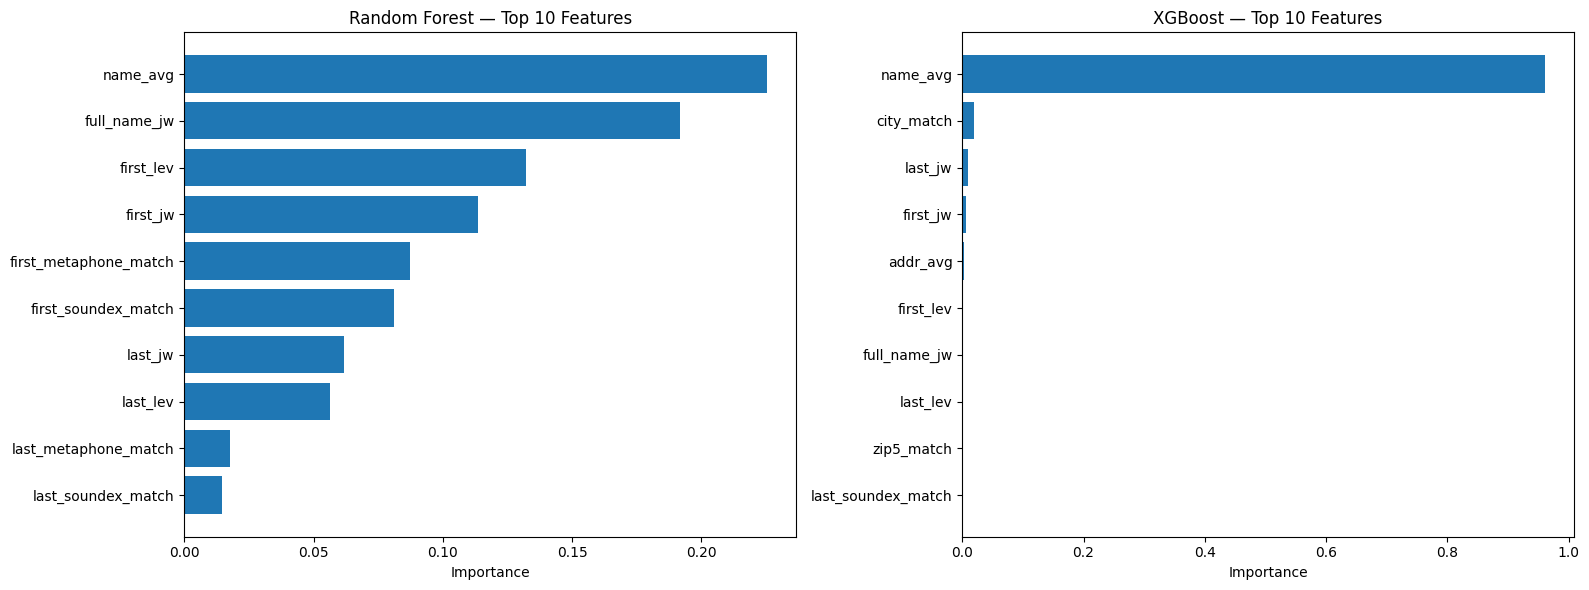

Saved feature_importance.png to ../artifacts/phase4_linkage/

--- Step 6: ROC curves ---


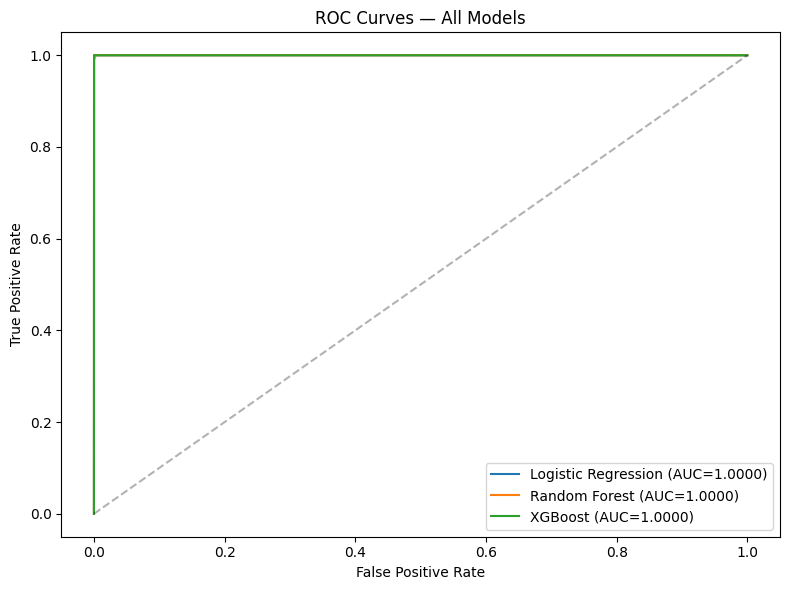

Saved roc_curves.png to ../artifacts/phase4_linkage/


In [ ]:
# ============================================================
# 4.7 (continued) FEATURE IMPORTANCE & ROC CURVES
# ============================================================

# --- Step 5: Feature importance ---
print("--- Step 5: Feature importance ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fi_models = []
if 'Random Forest' in results:
    fi_models.append(('Random Forest', results['Random Forest']['model'].feature_importances_))
if 'XGBoost' in results:
    fi_models.append(('XGBoost', results['XGBoost']['model'].feature_importances_))

for i, (name, importances) in enumerate(fi_models):
    fi_df = pd.DataFrame({'feature': FEATURE_COLS, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=True).tail(10)
    ax = axes[i] if len(fi_models) > 1 else axes[0]
    ax.barh(fi_df['feature'], fi_df['importance'])
    ax.set_title(f'{name} — Top 10 Features')
    ax.set_xlabel('Importance')
    print(f"\n{name} top features:")
    for _, row in fi_df.iloc[::-1].iterrows():
        print(f"  {row['feature']:30s} {row['importance']:.4f}")

# Hide unused axes if only 1 model has feature importance
if len(fi_models) < 2:
    axes[1].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved feature_importance.png to {OUTPUT_DIR}")

# --- Step 6: ROC curves ---
print("\n--- Step 6: ROC curves ---")

fig, ax = plt.subplots(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    ax.plot(fpr, tpr, label=f"{name} (AUC={res['test_auc']:.4f})")

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — All Models')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curves.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved roc_curves.png to {OUTPUT_DIR}")

In [ ]:
# ============================================================
# 4.7 (continued) — Step 7: Model comparison + ML-only audit
# ============================================================

print("--- Step 7: Model comparison ---\n")

comparison_rows = []
for name, res in results.items():
    comparison_rows.append({
        'Model': name,
        'Train AUC': f"{res['train_auc']:.4f}",
        'Test AUC': f"{res['test_auc']:.4f}",
        'CV AUC': f"{res['cv_auc_mean']:.4f}+/-{res['cv_auc_std']:.4f}",
        'Precision': f"{res['precision']:.4f}",
        'Recall': f"{res['recall']:.4f}",
        'F1': f"{res['f1']:.4f}",
    })

comparison_df = pd.DataFrame(comparison_rows)
print(comparison_df.to_string(index=False))

best_name = max(results, key=lambda n: results[n]['test_auc'])
print(f"\nBest model: {best_name} (Test AUC: {results[best_name]['test_auc']:.4f})")

# --- Step 8: Apply best model to FULL comp_df ---
print("\n--- Step 8: Apply best model to full dataset ---\n")

best_model = results[best_name]['model']
X_all = comp_df[FEATURE_COLS].values
comp_df['ml_match_prob'] = best_model.predict_proba(X_all)[:, 1]
comp_df['ml_match_pred'] = best_model.predict(X_all)

both_match = ((comp_df['match_tier'] == 'match') & (comp_df['ml_match_pred'] == 1)).sum()
rule_only  = ((comp_df['match_tier'] == 'match') & (comp_df['ml_match_pred'] == 0)).sum()
ml_only    = ((comp_df['match_tier'] != 'match') & (comp_df['ml_match_pred'] == 1)).sum()
neither    = ((comp_df['match_tier'] != 'match') & (comp_df['ml_match_pred'] == 0)).sum()

print(f"Agreement between rule-based and ML ({best_name}):")
print(f"  Both match:       {both_match:,}")
print(f"  Rule-only match:  {rule_only:,}")
print(f"  ML-only match:    {ml_only:,}")
print(f"  Neither match:    {neither:,}")
print(f"  Agreement rate:   {(both_match + neither) / len(comp_df) * 100:.2f}%")

# --- Step 9: Audit ML-only matches ---
print("\n--- Step 9: Audit ML-only matches ---\n")

ml_only_mask = (comp_df['ml_match_pred'] == 1) & (comp_df['match_tier'] != 'match')
ml_only_df = comp_df[ml_only_mask].copy()

print(f"ML-only matches: {len(ml_only_df):,}")
print(f"  From 'possible' tier: {(ml_only_df['match_tier'] == 'possible').sum():,}")
print(f"  From 'non_match' tier: {(ml_only_df['match_tier'] == 'non_match').sum():,}")
print(f"\nThese pairs are the SOLE incremental value of ML beyond rules.")
print(f"Without independent ground truth, their correctness cannot be verified.\n")

if len(ml_only_df) > 0:
    sample_cols = [
        'first_name_op', 'first_name_med',
        'last_name_op', 'last_name_med',
        'city_op', 'city_med',
        'first_jw', 'last_jw', 'zip5_match', 'ml_match_prob', 'match_tier'
    ]
    print("Top 15 ML-only matches by probability (manual review recommended):")
    print(ml_only_df.nlargest(15, 'ml_match_prob')[sample_cols].to_string(index=False))

rule_only_mask = (comp_df['ml_match_pred'] == 0) & (comp_df['match_tier'] == 'match')
rule_only_df = comp_df[rule_only_mask]
print(f"\nRule-only matches (ML disagrees): {len(rule_only_df):,}")
if len(rule_only_df) > 0:
    print(rule_only_df[['first_name_op','first_name_med','last_name_op','last_name_med',
                         'first_jw','last_jw','ml_match_prob','which_path']].to_string(index=False))


--- Step 7: Model comparison ---

              Model Train AUC Test AUC          CV AUC Precision Recall     F1
Logistic Regression    1.0000   1.0000 0.9999+/-0.0000    0.4315 1.0000 0.6029
      Random Forest    1.0000   1.0000 0.9999+/-0.0000    0.8834 0.9931 0.9351
            XGBoost    1.0000   1.0000 0.9999+/-0.0000    0.8720 0.9862 0.9256

Best model: Random Forest (Test AUC: 1.0000)

--- Step 8: Apply best model to full dataset ---

Agreement between rule-based and ML (Random Forest):
  Both match:       481
  Rule-only match:  1
  ML-only match:    80
  Neither match:    491,865
  Agreement rate:   99.98%

--- Step 9: Audit ML-only matches ---

ML-only matches: 80
  From 'possible' tier: 8
  From 'non_match' tier: 72

These pairs are the SOLE incremental value of ML beyond rules.
Without independent ground truth, their correctness cannot be verified.

Top 15 ML-only matches by probability (manual review recommended):
first_name_op first_name_med last_name_op last_name_med   

### 4.8 — Threshold Sensitivity Analysis [NEW]

Three-part sensitivity analysis:
1. **Rule-based threshold sweep**: Vary `first_jw` and `last_jw` thresholds in Path A, measure precision/recall
2. **ML probability threshold sweep**: Sweep decision threshold from 0.1 to 0.9 for the best ML model
3. **Bootstrap confidence intervals**: 1000 bootstrap resamples for 95% CIs on precision and recall

In [ ]:
# ============================================================
# 4.8 THRESHOLD SENSITIVITY ANALYSIS
# ============================================================

print("4.8 THRESHOLD SENSITIVITY ANALYSIS")
print("-" * 60)

# --- Step 1: Sweep rule-based thresholds ---
print("\n--- Step 1: Rule-based threshold sweep (Path A first_jw) ---")

first_jw_thresholds = [0.80, 0.82, 0.85, 0.88, 0.90, 0.92, 0.95]
last_jw_thresholds = [0.80, 0.82, 0.85, 0.88, 0.90, 0.92, 0.95]

def evaluate_with_path_a_threshold(first_thresh, last_thresh):
    """Re-run classification with modified Path A thresholds."""
    pa = (
        (comp_df['first_jw'] >= first_thresh) &
        (comp_df['last_jw'] >= last_thresh) &
        ((comp_df['zip5_match'] == 1.0) | (comp_df['street_jw'] >= 0.80))
    )
    mm = pa | path_b | path_c2 | path_d | path_e
    matched_ops = set(comp_df.loc[mm, 'index_op'].unique())
    matched_pairs = set(zip(comp_df.loc[mm, 'index_op'], comp_df.loc[mm, 'index_med']))
    
    # Recall: how many GT OP records did we find?
    recall_ops = len(gt_ops & matched_ops) / len(gt_ops) * 100 if gt_ops else 0
    # Precision: how many of our matched pairs are in GT?
    prec_pairs = len(matched_pairs & gt_pair_set) / len(matched_pairs) * 100 if matched_pairs else 0
    return recall_ops, prec_pairs, len(matched_ops)

# Sweep first_jw in Path A (last_jw fixed at 0.85)
print(f"\n{'first_jw Thresh':>15} {'Recall (%)':>12} {'Precision (%)':>14} {'Matches':>10}")
print("-" * 55)
for t in first_jw_thresholds:
    rec, prec, n = evaluate_with_path_a_threshold(t, 0.85)
    print(f"{t:>15.2f} {rec:>12.1f} {prec:>14.1f} {n:>10,}")

# Sweep last_jw in Path A (first_jw fixed at 0.85)
print(f"\n{'last_jw Thresh':>15} {'Recall (%)':>12} {'Precision (%)':>14} {'Matches':>10}")
print("-" * 55)
for t in last_jw_thresholds:
    rec, prec, n = evaluate_with_path_a_threshold(0.85, t)
    print(f"{t:>15.2f} {rec:>12.1f} {prec:>14.1f} {n:>10,}")

4.8 THRESHOLD SENSITIVITY ANALYSIS
------------------------------------------------------------

--- Step 1: Rule-based threshold sweep (Path A first_jw) ---

first_jw Thresh   Recall (%)  Precision (%)    Matches
-------------------------------------------------------
           0.80         98.2           92.5        400
           0.82         98.2           93.8        396
           0.85         98.2           94.6        393
           0.88         98.2           95.0        391
           0.90         98.2           95.0        391
           0.92         98.2           95.2        390
           0.95         98.2           95.6        388

 last_jw Thresh   Recall (%)  Precision (%)    Matches
-------------------------------------------------------
           0.80         98.2           91.9        404
           0.82         98.2           93.3        399
           0.85         98.2           94.6        393
           0.88         98.2           95.2        390
           0.

In [ ]:
# ============================================================
# 4.8 (continued) — ML threshold sweep + bootstrap CIs for ALL models
# ============================================================

print("--- Step 2: ML probability threshold sweep ---\n")

best_model_name = max(results, key=lambda n: results[n]['test_auc'])
best_res = results[best_model_name]

thresholds = np.arange(0.10, 0.95, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (best_res['y_proba'] >= thresh).astype(int)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    threshold_results.append({'threshold': thresh, 'precision': prec, 'recall': rec, 'f1': f1})

thresh_df = pd.DataFrame(threshold_results)
print(f"Threshold sweep for {best_model_name}:")
print("Threshold  Precision     Recall         F1")
for _, row in thresh_df.iterrows():
    print(f"  {row['threshold']:.2f}     {row['precision']:.4f}     {row['recall']:.4f}     {row['f1']:.4f}")

best_thresh_idx = thresh_df['f1'].idxmax()
best_thresh = thresh_df.loc[best_thresh_idx, 'threshold']
best_f1 = thresh_df.loc[best_thresh_idx, 'f1']
print(f"\nOptimal threshold (max F1): {best_thresh:.2f} (F1={best_f1:.4f})")

# --- Step 3: Bootstrap 95% CIs for ALL THREE models ---
print("\n--- Step 3: Bootstrap 95% CIs (all models) ---\n")

from sklearn.utils import resample

n_bootstrap = 1000
np.random.seed(42)

bootstrap_summary = []
for model_name, res in results.items():
    y_pred_model = res['y_pred']
    boot_prec, boot_rec, boot_f1 = [], [], []

    for b in range(n_bootstrap):
        idx = np.random.choice(len(y_test), size=len(y_test), replace=True)
        yt = y_test[idx]
        yp = y_pred_model[idx]
        if yt.sum() == 0:
            continue
        boot_prec.append(precision_score(yt, yp, zero_division=0))
        boot_rec.append(recall_score(yt, yp, zero_division=0))
        boot_f1.append(f1_score(yt, yp, zero_division=0))

    prec_lo, prec_hi = np.percentile(boot_prec, [2.5, 97.5])
    rec_lo, rec_hi = np.percentile(boot_rec, [2.5, 97.5])
    f1_lo, f1_hi = np.percentile(boot_f1, [2.5, 97.5])

    print(f"{model_name}:")
    print(f"  Precision: {res['precision']*100:.1f}%  95% CI [{prec_lo*100:.1f}%, {prec_hi*100:.1f}%]")
    print(f"  Recall:    {res['recall']*100:.1f}%  95% CI [{rec_lo*100:.1f}%, {rec_hi*100:.1f}%]")
    print(f"  F1:        {res['f1']*100:.1f}%  95% CI [{f1_lo*100:.1f}%, {f1_hi*100:.1f}%]")
    print()

    bootstrap_summary.append({
        'Model': model_name,
        'Precision': f"{res['precision']*100:.1f}% [{prec_lo*100:.1f}%, {prec_hi*100:.1f}%]",
        'Recall': f"{res['recall']*100:.1f}% [{rec_lo*100:.1f}%, {rec_hi*100:.1f}%]",
        'F1': f"{res['f1']*100:.1f}% [{f1_lo*100:.1f}%, {f1_hi*100:.1f}%]",
    })

boot_summary_df = pd.DataFrame(bootstrap_summary)
print("Bootstrap summary (1,000 resamples):")
print(boot_summary_df.to_string(index=False))


--- Step 2: ML probability threshold sweep ---

Threshold sweep for Random Forest:
Threshold  Precision     Recall         F1
  0.10     0.6971     1.0000     0.8215
  0.15     0.7713     1.0000     0.8709
  0.20     0.7967     1.0000     0.8869
  0.25     0.8192     1.0000     0.9006
  0.30     0.8529     1.0000     0.9206
  0.35     0.8623     0.9931     0.9231
  0.40     0.8727     0.9931     0.9290
  0.45     0.8834     0.9931     0.9351
  0.50     0.8834     0.9931     0.9351
  0.55     0.8834     0.9931     0.9351
  0.60     0.8882     0.9862     0.9346
  0.65     0.8882     0.9862     0.9346
  0.70     0.8882     0.9862     0.9346
  0.75     0.8924     0.9724     0.9307
  0.80     0.8924     0.9724     0.9307
  0.85     0.8917     0.9655     0.9272
  0.90     0.8917     0.9655     0.9272

Optimal threshold (max F1): 0.45 (F1=0.9351)

--- Step 3: Bootstrap 95% CIs (all models) ---

Logistic Regression:
  Precision: 43.2%  95% CI [38.0%, 48.6%]
  Recall:    100.0%  95% CI [100.0%,

### 4.9 — Export & Visualization [KEEP + ENHANCE]

Final exports and visualizations:
1. **Feature matrix**: `feature_matrix.parquet` + `.csv` with all similarity features, match_tier, which_path, ML predictions
2. **OP↔Medicare matches**: best match per OP record (highest raw_score)
3. **Similarity distributions**: 2×5 histogram grid colored by match tier
4. **Summary stats**: total matches, links, and unique physicians

In [ ]:
# ============================================================
# 4.9 EXPORT & VISUALIZATION
# ============================================================

print("4.9 EXPORT & VISUALIZATION")
print("-" * 60)

# --- Step 1: Export feature matrix ---
print("\n--- Step 1: Export feature matrix ---")

export_cols = [
    'index_op', 'index_med',
    'first_jw', 'first_lev', 'last_jw', 'last_lev',
    'first_soundex_match', 'last_soundex_match',
    'first_metaphone_match', 'last_metaphone_match',
    'street_jw', 'city_match', 'zip5_match',  # state_match removed (constant 1.0)
    'name_avg', 'addr_avg', 'raw_score',
    'name_len_ratio', 'full_name_jw',
    'match_tier', 'which_path',
    'ml_match_prob', 'ml_match_pred'
]

feature_matrix = comp_df[export_cols].copy()
feature_matrix.to_parquet(os.path.join(OUTPUT_DIR, 'feature_matrix.parquet'), index=False)
feature_matrix.to_csv(os.path.join(OUTPUT_DIR, 'feature_matrix.csv'), index=False)

print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Tier distribution:")
print(feature_matrix['match_tier'].value_counts().to_string())
print(f"Saved to {OUTPUT_DIR}feature_matrix.parquet and .csv")

# --- Step 2: Export OP↔Medicare confirmed matches ---
print("\n--- Step 2: Export OP↔Medicare confirmed matches ---")

match_df = comp_df[comp_df['match_tier'] == 'match'].copy()
# Keep best match per OP record (highest raw_score)
best_matches = (
    match_df
    .sort_values('raw_score', ascending=False)
    .drop_duplicates(subset='index_op', keep='first')
    .copy()
)

best_matches.to_parquet(os.path.join(OUTPUT_DIR, 'op_medicare_matches.parquet'), index=False)
print(f"OP↔Medicare confirmed matches: {len(best_matches):,}")
print(f"Saved to {OUTPUT_DIR}op_medicare_matches.parquet")


4.9 EXPORT & VISUALIZATION
------------------------------------------------------------

--- Step 1: Export feature matrix ---
Feature matrix shape: (492427, 22)
Tier distribution:
match_tier
non_match    491869
match           482
possible         76
Saved to ../artifacts/phase4_linkage/feature_matrix.parquet and .csv

--- Step 2: Export OP↔Medicare confirmed matches ---
OP↔Medicare confirmed matches: 393
Saved to ../artifacts/phase4_linkage/op_medicare_matches.parquet


--- Step 3: Similarity distribution plots ---


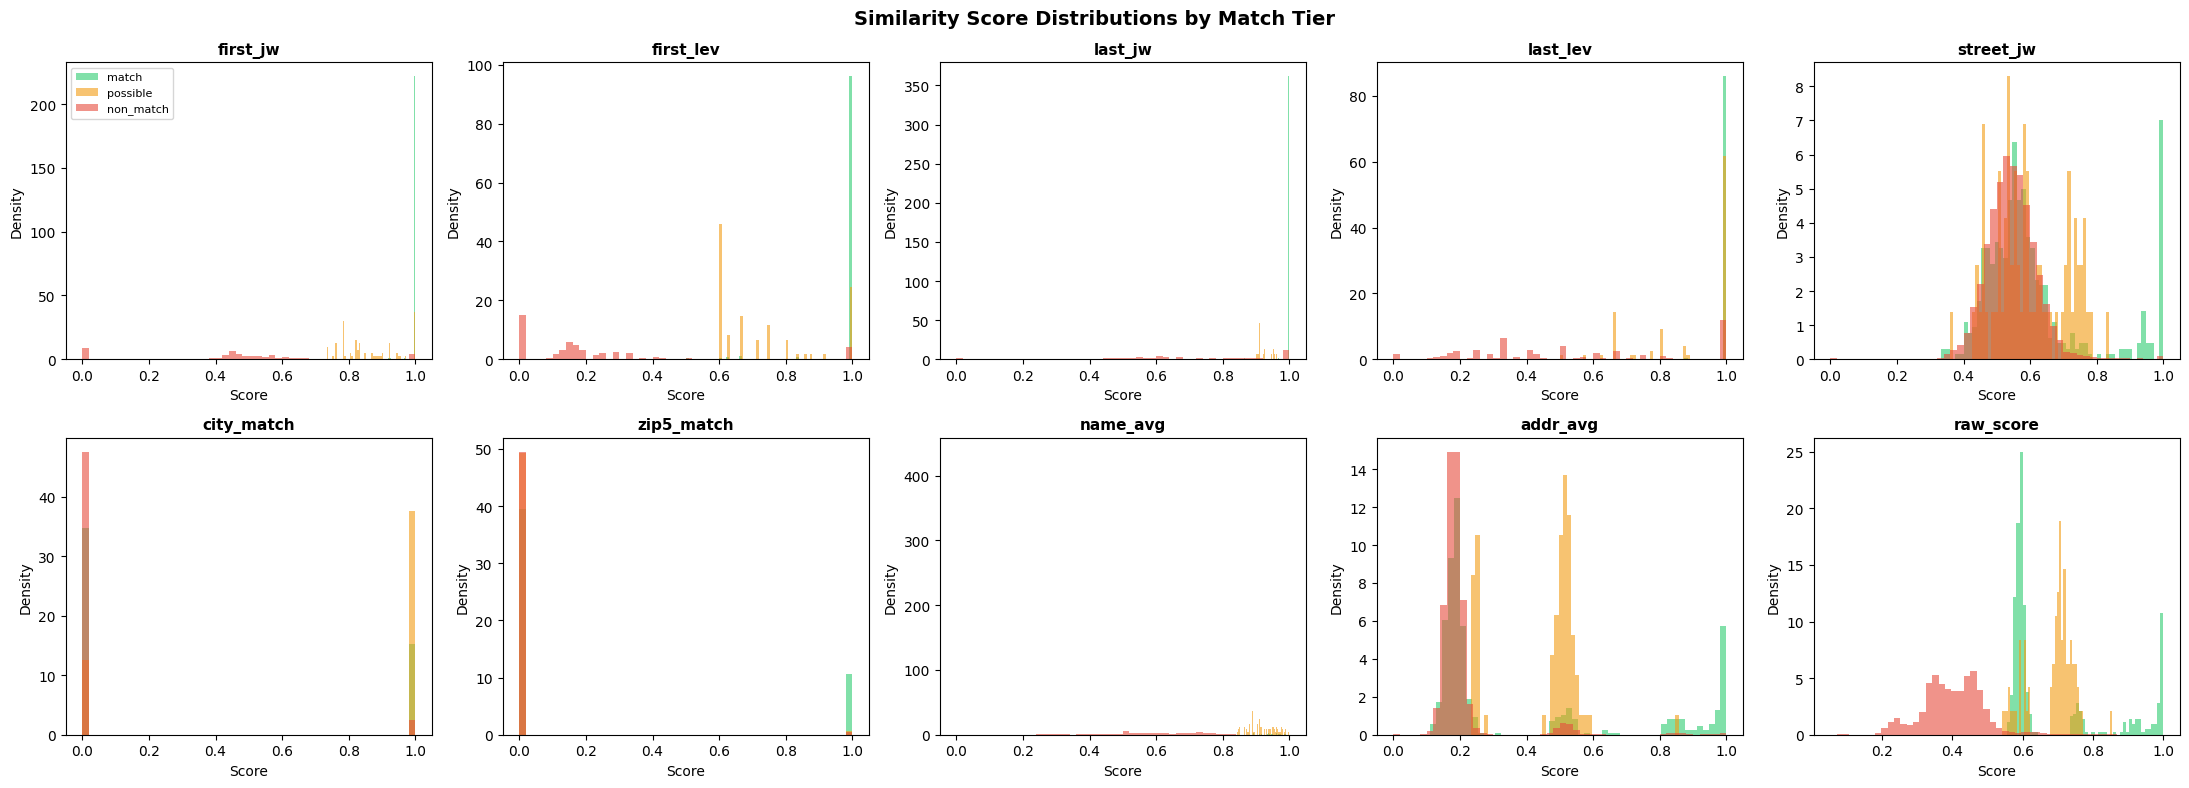

Saved similarity_distributions.png to ../artifacts/phase4_linkage/

PHASE 4 SUMMARY
Total OP↔Medicare matches:          393
Total Med↔PECOS canonical links:    1,084,185
Unique Med↔PECOS NPIs:              1,084,185
Unique OP records matched:           393

Files saved to ../artifacts/phase4_linkage/:
  feature_importance.png                            0.06 MB
  feature_matrix.csv                              100.18 MB
  feature_matrix.parquet                           13.34 MB
  med_pecos_tier1_npi.parquet                      35.03 MB
  medpecos_org_tier1_npi.parquet                    1.93 MB
  op_medicare_matches.parquet                       0.09 MB
  roc_curves.png                                    0.05 MB
  similarity_distributions.png                      0.11 MB


In [ ]:
# ============================================================
# 4.9 (continued) SIMILARITY DISTRIBUTIONS & SUMMARY
# ============================================================

# --- Step 3: Similarity distribution plots ---
print("--- Step 3: Similarity distribution plots ---")

sim_features = ['first_jw', 'first_lev', 'last_jw', 'last_lev',
                'street_jw', 'city_match', 'zip5_match',
                'name_avg', 'addr_avg', 'raw_score']

fig, axes = plt.subplots(2, 5, figsize=(22, 8))
axes = axes.flatten()

tiers = ['match', 'possible', 'non_match']
colors = {'match': '#2ecc71', 'possible': '#f39c12', 'non_match': '#e74c3c'}

for i, feat in enumerate(sim_features):
    ax = axes[i]
    for tier in tiers:
        subset = comp_df[comp_df['match_tier'] == tier][feat]
        if len(subset) > 0:
            ax.hist(subset, bins=50, alpha=0.6, label=tier,
                    color=colors[tier], density=True)
    ax.set_title(feat, fontsize=11, fontweight='bold')
    ax.set_xlabel('Score')
    ax.set_ylabel('Density')
    if i == 0:
        ax.legend(fontsize=8)

plt.suptitle('Similarity Score Distributions by Match Tier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'similarity_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved similarity_distributions.png to {OUTPUT_DIR}")

# --- Step 4: Summary stats ---
print("\n" + "=" * 60)
print("PHASE 4 SUMMARY")
print("=" * 60)
print(f"Total OP↔Medicare matches:          {len(best_matches):,}")
print(f"Total Med↔PECOS canonical links:    {len(tier1_canonical):,}")

# Unique physicians with at least 1 link
op_matched_npis = set()  # OP matches don't have NPI directly; count OP records matched
med_pecos_npis = set(med_pecos_tier1['Rndrng_NPI'].unique())
print(f"Unique Med↔PECOS NPIs:              {len(med_pecos_npis):,}")
print(f"Unique OP records matched:           {best_matches['index_op'].nunique():,}")

print(f"\nFiles saved to {OUTPUT_DIR}:")
for f in sorted(os.listdir(OUTPUT_DIR)):
    fpath = os.path.join(OUTPUT_DIR, f)
    if os.path.isfile(fpath):
        size_mb = os.path.getsize(fpath) / 1_048_576
        print(f"  {f:45s} {size_mb:>8.2f} MB")